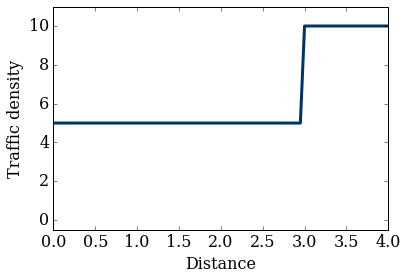

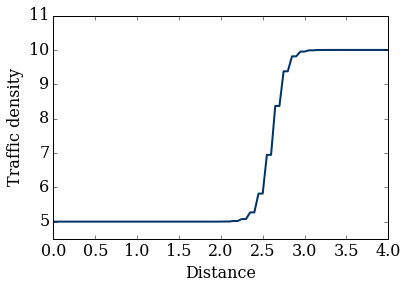

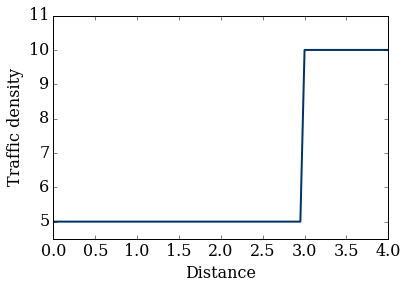

In [7]:
from traffic import rho_red_light, computeF

In [8]:
help(rho_red_light)

Help on function rho_red_light in module traffic:

rho_red_light(nx, rho_max, rho_in)



In [9]:
%matplotlib inline
import numpy 
from matplotlib import pyplot
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
from matplotlib import animation
from IPython.display import HTML

In [10]:
nx = 101
nt = 30
dx = 4.0/(nx-2)

rho_in = 5.
rho_max = 10.

V_max = 1.

x = numpy.linspace(0,4,nx-1)


rho = rho_red_light(nx-1, rho_max, rho_in)

In [11]:
def animate(data):
    x = numpy.linspace(0,4,nx-1)
    y = data
    line.set_data(x,y)
    return line,

In [13]:
def godunov(rho, nt, dt, dx, rho_max, V_max):

    rho_n = numpy.zeros((nt,len(rho)))      
    rho_n[:,:] = rho.copy()              
    
    #setup some temporary arrays
    rho_plus = numpy.zeros_like(rho)
    rho_minus = numpy.zeros_like(rho)
    flux = numpy.zeros_like(rho)
  
    for t in range(1,nt):
        
        rho_plus[:-1] = rho[1:]
        rho_minus = rho.copy()
        flux = 0.5 * (computeF(V_max, rho_max, rho_minus) + 
                      computeF(V_max, rho_max, rho_plus) + 
                      dx / dt * (rho_minus - rho_plus))
        rho_n[t,1:-1] = rho[1:-1] + dt/dx*(flux[:-2]-flux[1:-1])
        rho_n[t,0] = rho[0]
        rho_n[t,-1] = rho[-1]
        rho = rho_n[t].copy()
        
    return rho_n

In [14]:
sigma = 1.0
dt = sigma*dx/V_max

rho = rho_red_light(nx-1, rho_max, rho_in)      
rho_n = godunov(rho, nt, dt, dx, rho_max, V_max)

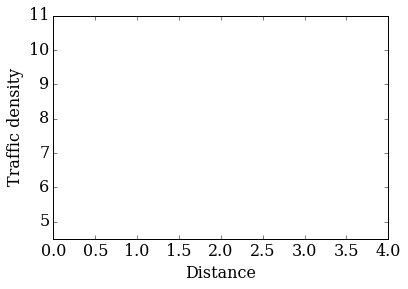

In [15]:
fig = pyplot.figure();
ax = pyplot.axes(xlim=(0,4),ylim=(4.5,11),xlabel=('Distance'),ylabel=('Traffic density'));
line, = ax.plot([],[],color='#003366', lw=2);

In [16]:
anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval=50)
HTML(anim.to_html5_video())

In [17]:
def minmod(e, dx):
    sigma = numpy.zeros_like(e)
    de_minus = numpy.ones_like(e)
    de_plus = numpy.ones_like(e)
    
    de_minus[1:] = (e[1:] - e[:-1])/dx
    de_plus[:-1] = (e[1:] - e[:-1])/dx
    
    for i in range(1, len(e)-1):
        if (de_minus[i] * de_plus[i] < 0.0):
            sigma[i] = 0.0
        elif (numpy.abs(de_minus[i]) < numpy.abs(de_plus[i])):
            sigma[i] = de_minus[i]
        else:
            sigma[i] = de_plus[i]
            
    return sigma

In [18]:
def muscl(rho, nt, dt, dx, rho_max, V_max):

   
    rho_n = numpy.zeros((nt,len(rho)))      
    rho_n[:,:] = rho.copy()              
    
    rho_plus = numpy.zeros_like(rho)
    rho_minus = numpy.zeros_like(rho)
    flux = numpy.zeros_like(rho)
    rho_star = numpy.zeros_like(rho)

    for t in range(1,nt):
               
        sigma = minmod(rho,dx) 
        
        rho_left = rho + sigma*dx/2.
        rho_right = rho - sigma*dx/2.     
        
        flux_left = computeF(V_max, rho_max, rho_left) 
        flux_right = computeF(V_max, rho_max, rho_right)
        
        #flux i = i + 1/2
        flux[:-1] = 0.5 * (flux_right[1:] + flux_left[:-1] - dx/dt *\
                          (rho_right[1:] - rho_left[:-1] ))
        
        #rk2 step 1
        rho_star[1:-1] = rho[1:-1] + dt/dx * (flux[:-2] - flux[1:-1])
        
        rho_star[0] = rho[0]
        rho_star[-1] = rho[-1]
        
        
        sigma = minmod(rho_star,dx) 
    
        rho_left = rho_star + sigma*dx/2.
        rho_right = rho_star - sigma*dx/2.
    
    
    
        flux_left = computeF(V_max, rho_max, rho_left) 
        flux_right = computeF(V_max, rho_max, rho_right)
        
        flux[:-1] = 0.5 * (flux_right[1:] + flux_left[:-1] - dx/dt *\
                          (rho_right[1:] - rho_left[:-1] ))
        
        rho_n[t,1:-1] = .5 * (rho[1:-1] + rho_star[1:-1] + dt/dx * (flux[:-2] - flux[1:-1]))
        
        rho_n[t,0] = rho[0]
        rho_n[t,-1] = rho[-1]
        rho = rho_n[t].copy()
        
    return rho_n

In [19]:
sigma = 1.
dt = sigma*dx/V_max
rho = rho_red_light(nx-1, rho_max, rho_in)    
rho_n = muscl(rho, nt, dt, dx, rho_max, V_max)

In [20]:
anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval=50)
HTML(anim.to_html5_video())